**Free Colab Pro** for students

# PyTorch Basics: A Complete Machine Learning Pipeline

In this session, we will translate the theoretical concepts of **Supervised Learning** into practical code. We will build a complete machine learning workflow from scratch using **PyTorch**.

The goal is to understand the standard paradigm of deep learning programming. We will break down the process into five canonical steps:

1.  **Data Preparation**: Generating synthetic data and wrapping it into PyTorch `Dataset` and `DataLoader`.
2.  **Model Design**: Defining a Neural Network architecture using `torch.nn.Module`.
3.  **Optimization Setup**: Choosing an appropriate `Loss Function` and `Optimizer`.
4.  **Training Loop**: Implementing the core iterative process (Forward $\to$ Loss $\to$ Backward $\to$ Update).
5.  **Evaluation & Visualization**: Assessing model performance and visualizing the fitted curve.

# 1. Problem Setup / Dataset

We consider a regression problem where the data $\{x_i, y_i\}$ satisfies:

$$y_i = f(x_i) + \epsilon_i$$

where $\epsilon_i$ represents the noise. The underlying function $f(x)$ is defined on the domain $x \in [-1, 1]$ as:

$$f(x) = \sin(10\pi x^2)$$

**Goal:** Train a neural network to approximate $f(x)$ using only the noisy observations.

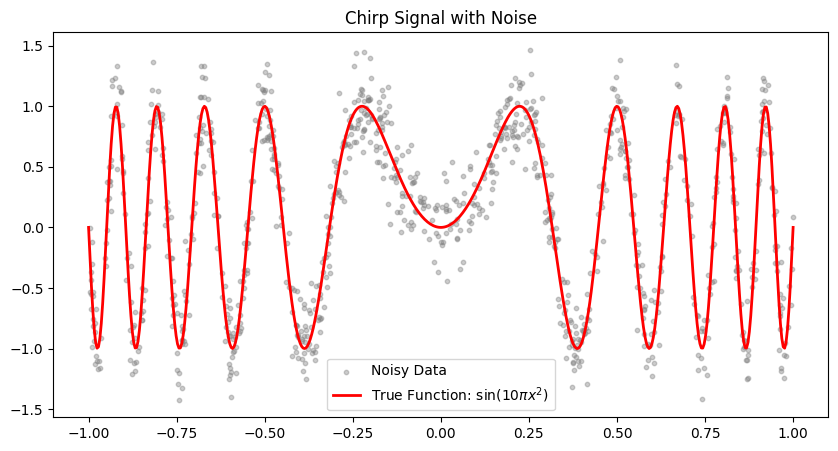

Data ready: 1000 samples, Batch size: 64


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def generate_data(n_samples=1000, sigma=0.1):
    """
    Generates synthetic data for the chirp signal regression task.

    Input:
        n_samples (int): Number of data points.
        sigma (float): Standard deviation of the Gaussian noise.
    Output:
        x (Tensor): Input features of shape (n_samples, 1).
        y (Tensor): Target values of shape (n_samples, 1).
    """
    # Generate uniform random inputs in [-1, 1]
    x = torch.rand(n_samples, 1) * 2 - 1

    # Compute the true function: sin(10 * pi * x^2)
    y_true = torch.sin(10 * torch.pi * x**2)

    # Add Gaussian noise
    noise = torch.randn(y_true.shape) * sigma
    y = y_true + noise

    return x, y

# --- 1. Data Generation ---
N_SAMPLES = 1000
NOISE_LEVEL = 0.2
BATCH_SIZE = 64

x_train, y_train = generate_data(n_samples=N_SAMPLES, sigma=NOISE_LEVEL)

# --- 2. Visualization ---
plt.figure(figsize=(10, 5))

# Create a dense grid for plotting the true curve
x_grid = torch.linspace(-1, 1, 500).unsqueeze(1)
y_grid = torch.sin(10 * torch.pi * x_grid**2)

plt.scatter(x_train, y_train, s=10, alpha=0.4, color='gray', label='Noisy Data')
plt.plot(x_grid, y_grid, color='red', linewidth=2, label=r'True Function: $\sin(10\pi x^2)$')
plt.title("Chirp Signal with Noise")
plt.legend()
plt.show()

# --- 3. DataLoader Setup ---
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Data ready: {len(train_dataset)} samples, Batch size: {BATCH_SIZE}")

## 1.1. TensorDataset & Custom Datasets

In the previous step, we used `TensorDataset`. It is a convenient wrapper when your data is already loaded into memory as Tensors.
* **Documentation**: [torch.utils.data.TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset)

**Beyond TensorDataset:**
In most real-world scenarios (e.g., training on ImageNet or large scientific datasets), it is impossible to load all data into RAM at once. Instead, we use a **Custom Dataset**.

To do this, we create a class that inherits from `torch.utils.data.Dataset` and implement three key methods:
1.  `__init__`: Initialize file paths or data configurations.
2.  `__len__`: Return the total number of samples.
3.  `__getitem__`: Load and return **one** sample given an index.

### Advanced Data Handling: Custom Dataset

In real-world projects, we often need to manipulate data on the fly. We will create a `CustomDataset` class that allows prior knowledge in the dataset:

1.  **Data Augmentation**: The function $\sin(10\pi x^2)$ is symmetric about $y$-axis. We can randomly flip the sign of $x$ without changing $y$ to increase data diversity.
2.  **Sample Reweighting**: The signal oscillates faster as $|x| \to 1$. High-frequency patterns are generally harder for neural networks to learn. We assign higher weights to samples with larger $|x|$ to force the model to focus on these difficult regions.

In [ ]:
from torch.utils.data import Dataset

class ChirpDataset(Dataset):
    """
    Custom dataset for Chirp signal with optional augmentation and weighting.
    """

    def __init__(self, data, target, augment=False, return_weights=False):
        """
        Args:
            data (Tensor): Input features x.
            target (Tensor): Label values y.
            augment (bool): If True, randomly flip sign of x.
            return_weights (bool): If True, return (x, y, w) tuple.
        """
        self.data = data
        self.target = target
        self.augment = augment
        self.return_weights = return_weights

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 1. Load data and target
        x = self.data[idx]
        y = self.target[idx]

        # 2. Apply Augmentation (Random Sign Flip)
        # Since f(x) = sin(10*pi*x^2), f(x) == f(-x). Flipping x is valid.
        if self.augment:
            if torch.rand(1).item() < 0.5:
                x = -x

        # 3. Calculate Weights (if requested)
        # Weight rule: w = 1 + |x|.
        # This gives higher importance (up to 2x) to high-frequency regions near edges.
        if self.return_weights:
            weight = 1.0 + torch.abs(x)
            return x, y, weight

        return x, y

# --- Usage Example ---

# Case 1: Standard training (No augmentation)
train_ds_basic = ChirpDataset(x_train, y_train, augment=False, return_weights=False)
loader_basic = DataLoader(train_ds_basic, batch_size=64, shuffle=True)

# Case 2: Advanced training (With augmentation and weights)
train_ds_advanced = ChirpDataset(x_train, y_train, augment=True, return_weights=True)
loader_advanced = DataLoader(train_ds_advanced, batch_size=64, shuffle=True)

# Verify the output
print("Basic Loader Sample:")
for x, y in loader_basic:
    print(f"Shapes - x: {x.shape}, y: {y.shape}")
    break

print("\nAdvanced Loader Sample (x, y, w):")
for batch in loader_advanced:
    # Unpack based on return length
    x, y, w = batch
    print(f"Shapes - x: {x.shape}, y: {y.shape}, w: {w.shape}")
    print(f"Sample Weight: {w[0].item():.4f} (for x={x[0].item():.4f})")
    break

Basic Loader Sample:
Shapes - x: torch.Size([64, 1]), y: torch.Size([64, 1])

Advanced Loader Sample (x, y, w):
Shapes - x: torch.Size([64, 1]), y: torch.Size([64, 1]), w: torch.Size([64, 1])
Sample Weight: 1.4224 (for x=-0.4224)


## 1.2 Important Considerations for Data Pipelines

Defining a `Dataset` class is only the first step. In scientific machine learning and real-world applications, how you handle data preprocessing and memory management is often more critical than the model architecture itself. Here are four key concepts to keep in mind:

### 1. Data Normalization & Standardization
Neural networks struggle when input features have vastly different scales (e.g., temperature in Kelvin vs. pressure in Pascals). Large input values can lead to exploding gradients or slow convergence.
* **Standardization**: Subtract the mean and divide by the standard deviation ($\mu=0, \sigma=1$).
* **Normalization**: Scale data to a fixed range, typically $[-1, 1]$ or $[0, 1]$.
* **Crucial Rule (Data Leakage)**: Always compute statistics (mean, min, max) using **only the Training Set**. Apply these stored statistics to transform the Validation and Test sets. Never use global statistics, as this "leaks" future information into the training process.

### 2. Eager Loading vs. Lazy Loading
* **Eager Loading**: Loading all data into RAM during `__init__`.
    * *Pros*: Fast access during training.
    * *Cons*: Limited by system RAM. Impossible for large datasets (e.g., ImageNet, terabytes of simulation data).
* **Lazy Loading**: Storing only file paths or metadata in `__init__`. The actual data is loaded from the disk inside `__getitem__`.
    * *Pros*: Scalable to infinite dataset sizes.
    * *Cons*: I/O latency becomes the bottleneck (mitigated by using `num_workers > 0` in DataLoader).

### 3. Data Splitting
Never evaluate your model on the data it was trained on. A standard workflow involves three subsets:
* **Training Set**: Used to compute gradients and update weights.
* **Validation Set**: Used to tune hyperparameters (learning rate, architecture) and monitor overfitting (Early Stopping).
* **Test Set**: Used **only once** at the very end to report final performance.
* *Implementation*: Use `torch.utils.data.random_split` to create these subsets reproducibly.

### 4. Custom Batching (`collate_fn`)
The default `DataLoader` assumes that every sample in a batch has the exact same tensor shape so it can stack them.
* **The Problem**: In many domains (e.g., variable-length time series, graphs with different node counts, NLP), samples have different sizes.
* **The Solution**: You can pass a custom function to the `collate_fn` argument in `DataLoader`. This function defines how a list of individual samples should be combined into a batch (e.g., via padding or returning a Python list instead of a stacked Tensor).

### 5. Data Augmentation & Prior Knowledge
Data augmentation is not just about increasing dataset size; it is a mechanism to explicitly encode **prior knowledge** and **invariances** into the training process.
* **Encoding Symmetries**: By transforming inputs (e.g., rotation, translation, or scaling) while keeping the target output fixed, you teach the model that the underlying features are **invariant** to these changes.
* **Stability**: This forces the model to learn robust representations that are stable against perturbations, rather than memorizing specific pixel or feature arrangements.

### 6. Parallel Data Loading
Deep learning workflows are often I/O bound, meaning the high-speed GPU sits idle while waiting for the CPU to read and process data.
* **Multiprocessing**: The `DataLoader` can use multiple CPU subprocesses (`num_workers > 0`) to load and preprocess batches in the background. This "prefetching" mechanism ensures a steady stream of data is always ready for the GPU, maximizing throughput.
* **Note on Randomness**: When using parallel workers, standard random number generators might duplicate seeds across processes. You may need a `worker_init_fn` to ensure independent randomness (e.g., for noise injection) in each worker.

# 2. Model Architecture

Now that we have our data ready, we need to design a function approximator. For this task, we will use a **Multi-Layer Perceptron (MLP)**.

Instead of hard-coding a specific network structure, it is best practice to define a **flexible architecture**. This allows us to treat structural parameters (like depth and width) as hyperparameters that we can tune to improve performance.

In the code below, we define a `FlexibleMLP` class where you can easily configure:
* **`hidden_dim`**: The width of the layers.
* **`num_hidden_layers`**: The depth of the network.
* **`activation`**: The non-linear activation function (e.g., `nn.Tanh`, `nn.ReLU`).

We typically use `nn.Tanh` for smooth function approximation tasks like this one, as it provides continuous derivatives unlike `nn.ReLU`.

In [ ]:
import torch
import torch.nn as nn

class FlexibleMLP(nn.Module):
    """
    A configurable Multi-Layer Perceptron (MLP) architecture.
    It allows dynamic adjustments of depth, width, and activation functions.
    """

    def __init__(self, input_dim, output_dim, hidden_dim=128, num_hidden_layers=3, activation=nn.Tanh):
        """
        Args:
            input_dim (int): Input feature dimension.
            output_dim (int): Output label dimension.
            hidden_dim (int): Number of neurons in each hidden layer.
            num_hidden_layers (int): Number of hidden layers (excluding output layer).
            activation (nn.Module class): The activation function class (e.g., nn.Tanh, nn.ReLU).
        """
        super(FlexibleMLP, self).__init__()

        layers = []

        # 1. Input Layer -> First Hidden Layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation())

        # 2. Intermediate Hidden Layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation())

        # 3. Output Layer (Linear, usually no activation for regression)
        layers.append(nn.Linear(hidden_dim, output_dim))

        # Register all layers as a Sequential module
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## 2.1. Beyond MLP: A Tour of Classic Architectures

While we are using a **Multi-Layer Perceptron (MLP)** for this 1D regression task, modern Deep Learning relies on specialized architectures designed to handle specific data structures (images, sequences, etc.) or to solve training difficulties.

Here are some milestone architectures you should know:

### 1. The Universal Approximator: MLP
The architecture we are using today.
* **Key Concept**: The **Universal Approximation Theorem** states that a feed-forward network with a single hidden layer (and sufficient width) can approximate any continuous function.
* **Relevance**: It is the building block of almost all deep learning models.
* **Paper**: [Approximation by Superpositions of a Sigmoidal Function (Cybenko, 1989)](https://link.springer.com/article/10.1007/BF00332918) or [Multilayer Feedforward Networks are Universal Approximators (Hornik et al., 1989)](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208)

### 2. Convolutional Neural Networks (CNNs)
The architecture that sparked the modern Deep Learning revolution.
* **Key Concept**: **Convolution** and **Pooling**. Instead of fully connected layers, it uses shared weights (filters) to scan the input, making it translation invariant and highly efficient for grid data (images, time-series, PDEs).
* **Relevance**: Standard for Image Processing and solving PDEs on regular grids.
* **Paper**: [ImageNet Classification with Deep Convolutional Neural Networks (Krizhevsky et al., 2012)](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

### 3. Residual Networks (ResNet)
Perhaps the most important architectural innovation for training **deep** networks.
* **Key Concept**: **Skip Connections** (or Shortcut Connections). Instead of learning $H(x)$, layers learn the residual $F(x) = H(x) - x$. This allows gradients to flow through the network without vanishing, enabling the training of networks with 100+ or 1000+ layers.
* **Relevance**: Essential for Deep Scientific Learning to capture multi-scale physics without gradient instability.
* **Paper**: [Deep Residual Learning for Image Recognition (He et al., 2016)](https://arxiv.org/abs/1512.03385)

### 4. U-Net
A specialized CNN architecture originally for biomedical image segmentation.
* **Key Concept**: **Encoder-Decoder** structure with skip connections between corresponding encoder and decoder layers. It captures context (low resolution) and localization (high resolution) simultaneously.
* **Relevance**: The gold standard for **Image-to-Image** tasks and **Inverse Problems** (e.g., mapping a noisy seismic wave field to a velocity model).
* **Paper**: [U-Net: Convolutional Networks for Biomedical Image Segmentation (Ronneberger et al., 2015)](https://arxiv.org/abs/1505.04597)

### 5. Transformers
The current state-of-the-art in NLP and increasingly in Vision/Science.
* **Key Concept**: **Self-Attention Mechanism**. It allows the model to weigh the importance of different parts of the input data regardless of their distance, discarding the sequential bias of RNNs.
* **Relevance**: Foundation models (GPT, BERT) and Neural Operators (Transformer-based FNO).
* **Paper**: [Attention Is All You Need (Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762)

## 2.2 Advanced Architectural Concepts

While standard layers like `nn.Linear` and `nn.Conv2d` cover most use cases, PyTorch allows for deep customization. Here are a few advanced concepts related to model architecture that you should be aware of:

### 1. Custom Layers
You are not limited to the pre-defined layers in `torch.nn`. You can create your own layer by defining a class that inherits from `nn.Module`.
* **Use Case**: Implementing a specific physical formula, a non-standard activation function, or a domain-specific operation (e.g., a Fourier Transform layer) directly into the gradient flow.
* **Mechanism**: You simply define parameters in `__init__` using `nn.Parameter` and define the computation in `forward`.

### 2. Weight Initialization
How you initialize your model's parameters (weights and biases) can significantly impact convergence speed and stability.
* **The Problem**: If weights are initialized too small, gradients vanish; if too large, they explode.
* **Tools**: `torch.nn.init` provides methods like **Xavier (Glorot) initialization** (good for Tanh/Sigmoid) and **Kaiming (He) initialization** (good for ReLU). While PyTorch layers have sensible defaults, manual initialization is often necessary for specialized architectures.

### 3. Regularization Layers
Some "layers" are not designed to learn features but to improve training stability or prevent overfitting.
* **Dropout (`nn.Dropout`)**: Randomly zeroes out some elements of the input tensor during training. This prevents neurons from co-adapting too much and acts as an ensemble method.
* **Normalization (`nn.BatchNorm`, `nn.LayerNorm`)**: Normalizes the input to have zero mean and unit variance. This stabilizes the learning process and allows the use of higher learning rates.

### 4. Dynamic Connectivity (Beyond `nn.Sequential`)
In our simple example, we used `nn.Sequential` for a linear stack of layers. However, defining the `forward` method manually gives you complete control.
* **Skip Connections**: You can implement Residual connections (ResNet) by simply doing `output = layer(x) + x`.
* **Multiple Inputs/Outputs**: Your model can take multiple tensors as input (e.g., spatial coordinates `x` and time `t`) and process them through different branches before merging.

# 3. Optimization Setup: Loss and Optimizer

We frame the training of the neural network as an **optimization problem**. Our goal is to find the set of parameters $\theta$ that **minimizes** a specific objective function. This requires two key components:

1.  **The Loss Function**: Defines the objective to be minimized.
2.  **The Optimizer**: The algorithm that updates the parameters $\theta$ based on gradients to reduce the loss.

While PyTorch provides standard loss functions (like `nn.MSELoss`), it is highly flexible: **any differentiable function** can serve as a custom objective. This is particularly important in scientific computing, where we often need to incorporate physical constraints or weighted penalties.

In [ ]:
import torch
import torch.nn as nn

# --- Option 1: Functional Implementation ---
def weighted_mse_loss_fn(prediction, target, weight=None):
    """
    Computes Weighted Mean Squared Error as a standalone function.

    Args:
        prediction (Tensor): Model output.
        target (Tensor): Ground truth.
        weight (Tensor, optional): Importance weight for each sample.
    """
    loss = (prediction - target) ** 2
    if weight is not None:
        loss = loss * weight
    return loss.mean()


# --- Option 2: Class-based Implementation (nn.Module) ---
class WeightedMSELoss(nn.Module):
    """
    Computes Weighted Mean Squared Error as a module.
    Useful when integration into a larger pipeline or state management is needed.
    """
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, prediction, target, weight=None):
        """
        Calculates the loss during the forward pass.

        Args:
            prediction (Tensor): Model output.
            target (Tensor): Ground truth.
            weight (Tensor, optional): Importance weight for each sample.
        """
        loss = (prediction - target) ** 2
        if weight is not None:
            loss = loss * weight
        return loss.mean()

# Usage Examples (Mental check):
# loss = weighted_mse_loss_fn(pred, target, w)
# criterion = WeightedMSELoss(); loss = criterion(pred, target, w)

## 3.1 Advanced PyTorch Implementation Details for the Loss

In research, simply calling `criterion(y_pred, y_true)` is rarely enough. Here are three critical engineering aspects of Loss Functions in PyTorch that you need to master:

### 1. Reduction Modes (`reduction='none'`)
Standard PyTorch loss functions (like `MSELoss`) average the error over the batch by default (`reduction='mean'`). However, scientific applications often require granular control.
* **The Feature**: Setting `reduction='none'` returns the loss for **each individual sample** as a vector, rather than a single scalar.
* **Why use it?**
    * **Per-sample Weighting**: If your weights are complex or computed dynamically, you calculate raw losses first and multiply by weights manually.
    * **Debugging**: You can inspect which specific samples have the highest error (e.g., "Is the model failing at the boundaries $x=\pm 1$?").

### 2. The Broadcasting Trap (Shape Safety)
A common "silent bug" occurs when tensor shapes do not match exactly.
* **Scenario**: `prediction` has shape `(64, 1)` but `target` has shape `(64,)`.
* **The Bug**: PyTorch will **broadcast** the subtraction, resulting in a `(64, 64)` matrix instead of a `(64, 1)` vector. The code runs without error, but the loss is mathematically wrong.
* **Best Practice**: Always ensure shapes match explicitly before calculating loss:
    ```python
    # Safe practice
    loss = criterion(prediction.squeeze(), target.squeeze())
    ```

### 3. Multi-Objective Optimization
In Inverse Problems, we often combine a data-fitting term with a regularization term (e.g., physical constraints).
* **Implementation**: Since PyTorch builds a dynamic computational graph, you can simply sum the losses. Autograd handles the chain rule for the combined objective.

$$ \mathcal{L}_{total} = \mathcal{L}_{data} + \lambda \cdot \mathcal{L}_{reg} $$
* **Code**:
    ```python
    loss_data = mse(pred, target)
    loss_reg = torch.mean(model.weights ** 2) # L2 Regularization
    total_loss = loss_data + 1e-4 * loss_reg
    total_loss.backward() # Gradients flow to both terms
    ```

## 3.2 The Optimizer

The optimizer is the algorithm that updates the model parameters $\theta$ to minimize the loss function. It determines *how* the network learns.

**Common Optimizers:**
1.  **SGD (Stochastic Gradient Descent)**: The classic approach. It updates weights based on the gradient of the current batch. It is robust but can be slow to converge and sensitive to the learning rate.
2.  **Adam (Adaptive Moment Estimation)**: The default choice for most deep learning tasks. It computes adaptive learning rates for each parameter. It generally converges faster than SGD and requires less tuning.

**The Learning Rate ($\eta$):**
This is arguably the most critical hyperparameter. In gradient-based optimization, the learning rate serves as the **step size**. It is the coefficient that scales the gradient during the parameter update. For example, the update rule for standard SGD is:

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta \mathcal{L}(\theta_t)$$

In [ ]:
import torch.optim as optim

def get_optimizer(model, opt_type='adam', learning_rate=1e-3):
    """
    Initializes the optimizer for the model.

    Input:
        model (nn.Module): The neural network.
        opt_type (str): 'adam' or 'sgd'.
        learning_rate (float): Step size for updates.
    Output:
        optimizer (torch.optim.Optimizer): The configured optimizer.
    """
    if opt_type.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif opt_type.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer type: {opt_type}")

# Example usage
# optimizer = get_optimizer(model, opt_type='adam', lr=0.01)
# print(f"Optimizer initialized: {type(optimizer).__name__}")

## 3.3 Advanced Optimization Concepts

While standard Adam works well for most of the problems, scientific research and large-scale training often require specialized tools and a deeper understanding of optimizer hyperparameters.

### 1. Modern Optimizers

* **AdamW**: [Documentation](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)
    * **What it is**: A modification of Adam that **decouples** weight decay from the gradient update.
    * **Why use it**: It is the standard for training Transformers (LLMs, ViT). It generally generalizes better than Adam because the L2 regularization is applied more correctly during the adaptive update.
* **L-BFGS**: [Documentation](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html)
    * **What it is**: A Quasi-Newton method that uses second-order information (Hessian approximation) to guide updates.
    * **Use Case**: Extremely popular in **Scientific Machine Learning (e.g., PINNs)**. It is computationally expensive per step but converges in very few steps, making it ideal for small datasets requiring high precision (low loss).
* **Muon (Momentumized Orthogonal)**: [GitHub / Paper](https://github.com/KellerJordan/Muon)
    * **What it is**: An emerging optimizer designed for massive matrix-based models (like Transformers). It performs updates based on the **Spectral Norm** of the weights and orthogonalizes updates using Newton-Schulz iterations.
    * **Use Case**: It is currently setting records for training efficiency in high-dimensional spaces, often converging faster than AdamW for large-scale runs.

### 2. Key Optimizer Parameters
Understanding these two arguments is crucial for tuning advanced optimizers:

* **Weight Decay ($\lambda$)**:
    * **Concept**: A regularization term that adds a penalty $\lambda \|\theta\|^2$ to the loss.
    * **Effect**: It forces the model weights to remain small (close to zero). This prevents overfitting and improves generalization, especially in over-parameterized models.
* **Momentum ($\beta$)**:
    * **Concept**: Instead of updating parameters based solely on the current gradient $g_t$, we update based on a moving average of past gradients: $v_t = \beta v_{t-1} + (1-\beta)g_t$.
    * **Effect**: It helps the optimizer build up speed in directions with consistent gradients and dampens oscillations in chaotic valleys. Think of it as a heavy ball rolling down a hill—it resists being thrown off course by small bumps.

### 3. Learning Rate Schedulers
A constant learning rate is often suboptimal. We typically use a **Scheduler** to adjust $\eta$ dynamically.

* **StepLR**: Decays the learning rate by a factor (e.g., 0.1) every $N$ epochs.
* **CosineAnnealingLR**: Smoothly decreases the learning rate following a cosine curve from $\eta_{max}$ to 0. This is the gold standard for modern training pipelines as it avoids sudden drops.
* **Documentation**: [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

# 4. Training Loop, Evaluation, and Visualization

| Exp ID | Activation | Weights? | Augmentation? | Architecture |
| :--- | :--- | :---: | :---: | :--- |
| **1** | Tanh | ❌ | ❌ | 3 layers / 128 |
| **2** | ReLU | ❌ | ❌ | 3 layers / 128 |
| **3** | GELu | ❌ | ❌ | 3 layers / 128 |
| **4** | GELu | ✅ | ❌ | 3 layers / 128 |
| **5** | GELu | ✅ | ✅ | 3 layers / 128 |
| **6** | GELU | ✅ | ✅ | 6 layers / 256 |

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split

# ==========================================
# 1. Class & Function Definitions
# ==========================================

def generate_data(n_samples=1000, sigma=0.1):
    """Generates synthetic data for the chirp signal regression task."""
    torch.manual_seed(42)
    x = torch.rand(n_samples, 1) * 2 - 1
    y_true = torch.sin(10 * torch.pi * x**2)
    noise = torch.randn(y_true.shape) * sigma
    y = y_true + noise
    return x, y

class ChirpDataset(Dataset):
    """Custom dataset for Chirp signal with optional augmentation and weighting."""
    def __init__(self, data, target, augment=False, return_weights=False):
        self.data = data
        self.target = target
        self.augment = augment
        self.return_weights = return_weights

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]
        if self.augment:
            if torch.rand(1).item() < 0.5: x = -x
        if self.return_weights:
            weight = 1 + 2 * torch.abs(x)**2
            return x, y, weight
        return x, y

class FlexibleMLP(nn.Module):
    """A configurable Multi-Layer Perceptron (MLP) architecture."""
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_hidden_layers=3, activation=nn.Tanh):
        super(FlexibleMLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation())
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class WeightedMSELoss(nn.Module):
    """Computes Weighted Mean Squared Error."""
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, prediction, target, weight=None):
        loss = (prediction - target) ** 2
        if weight is not None: loss = loss * weight
        return loss.mean()

def get_optimizer(model, opt_type='Adam', lr=1e-3, weight_decay=0.0, momentum=0.9):
    """Initializes the optimizer."""
    if opt_type == 'Adam':
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt_type == 'AdamW':
        return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif opt_type == 'SGD':
        return optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {opt_type}")

# ==========================================
# 2. Interactive Training Pipeline
# ==========================================

# @title Training Configuration
# @markdown ### 1. Dataset Settings
N_SAMPLES = 2500 # @param {type:"slider", min:500, max:5000, step:100}
NOISE_LEVEL = 0.1 # @param {type:"number"}
USE_AUGMENTATION = False # @param {type:"boolean"}
USE_WEIGHTS = True # @param {type:"boolean"}

# @markdown ### 2. Model Architecture
HIDDEN_DIM = 128 # @param {type:"integer"}
NUM_LAYERS = 4 # @param {type:"integer"}
ACTIVATION_TYPE = "GELU" # @param ["Tanh", "ReLU", "GELU"]

# @markdown ### 3. Optimization
OPTIMIZER_TYPE = "AdamW" # @param ["Adam", "AdamW", "SGD"]
LEARNING_RATE = 0.002 # @param {type:"number"}
WEIGHT_DECAY = 1e-4 # @param {type:"number"}
MOMENTUM = 0.99 # @param {type:"number"}

# @markdown ### 4. Training Loop
NUM_EPOCHS = 300 # @param {type:"integer"}
BATCH_SIZE = 2000 # @param {type:"integer"}
TEST_INTERVAL = 10 # @param {type:"integer"}

# @markdown ### 5. Visualization
GENERATE_ANIMATION = True # @param {type:"boolean"}

def run_experiment():
    # --- A. Device Setup ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on device: {device}")

    # --- B. Data Preparation ---
    x_full, y_full = generate_data(n_samples=N_SAMPLES, sigma=NOISE_LEVEL)
    dataset_full = TensorDataset(x_full, y_full)
    train_size = int(0.8 * len(dataset_full))
    test_size = len(dataset_full) - train_size
    train_subset, test_subset = random_split(dataset_full, [train_size, test_size])

    x_train, y_train = x_full[train_subset.indices], y_full[train_subset.indices]
    x_test, y_test = x_full[test_subset.indices], y_full[test_subset.indices]

    train_ds = ChirpDataset(x_train, y_train, augment=USE_AUGMENTATION, return_weights=USE_WEIGHTS)
    test_ds = ChirpDataset(x_test, y_test, augment=False, return_weights=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Data Loaded: {len(train_ds)} Training samples, {len(test_ds)} Test samples.")

    # --- C. Model Initialization ---
    act_map = {"Tanh": nn.Tanh, "ReLU": nn.ReLU, "GELU": nn.GELU}
    model = FlexibleMLP(input_dim=1, output_dim=1,
                        hidden_dim=HIDDEN_DIM, num_hidden_layers=NUM_LAYERS,
                        activation=act_map[ACTIVATION_TYPE]).to(device)

    # --- D. Optimizer & Loss ---
    optimizer = get_optimizer(model, opt_type=OPTIMIZER_TYPE, lr=LEARNING_RATE,
                              weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
    criterion = WeightedMSELoss()

    # --- E. Training Loop ---
    train_loss_history = []
    test_loss_history = []
    snapshots = [] # Store (epoch, y_pred) for animation

    x_grid = torch.linspace(-1, 1, 1000).unsqueeze(1).to(device)
    y_grid_true = torch.sin(10 * torch.pi * x_grid**2).cpu().numpy()

    print("Starting training...")
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            if USE_WEIGHTS:
                x, y, w = batch
                x, y, w = x.to(device), y.to(device), w.to(device)
            else:
                x, y = batch
                x, y = x.to(device), y.to(device)
                w = None

            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y, weight=w)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        if (epoch + 1) % TEST_INTERVAL == 0 or epoch == 0:
            model.eval()
            test_losses = []
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    pred = model(x)
                    loss = criterion(pred, y, weight=None)
                    test_losses.append(loss.item())

                # Only save snapshot if animation is requested (save memory/time)
                if GENERATE_ANIMATION:
                    y_grid_pred = model(x_grid).cpu().numpy()
                    snapshots.append((epoch + 1, y_grid_pred))

            avg_test_loss = np.mean(test_losses)
            test_loss_history.append((epoch + 1, avg_test_loss))

            if (epoch + 1) % (NUM_EPOCHS // 5) == 0:
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.6f} | Test MSE: {avg_test_loss:.6f}")

    # --- F. Static Visualization ---
    print("\nPlotting Final Results...")
    fig = plt.figure(figsize=(18, 5))

    # 1. Train Loss
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(train_loss_history, label='Train Loss')
    ax1.set_title('Training Convergence')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.set_yscale('log')
    ax1.legend()

    # 2. Test Error
    ax2 = fig.add_subplot(1, 3, 2)
    test_epochs_static, test_errors_static = zip(*test_loss_history)
    ax2.plot(test_epochs_static, test_errors_static, color='orange', label='Test MSE')
    ax2.set_title('Test Set Error')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('MSE'); ax2.set_yscale('log')
    ax2.legend()

    # 3. Final Fit
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(x_test.cpu().numpy(), y_test.cpu().numpy(), s=5, color='gray', alpha=0.2)
    ax3.plot(x_grid.cpu().numpy(), y_grid_true, 'g--', linewidth=1.5)
    model.eval()
    with torch.no_grad(): final_pred = model(x_grid).cpu().numpy()
    ax3.plot(x_grid.cpu().numpy(), final_pred, 'r-', linewidth=2)
    ax3.set_title(f'Final Fit (Test MSE: {test_errors_static[-1]:.4f})')

    plt.tight_layout()
    plt.show()

    # --- G. Animation Generation (Conditional) ---
    if GENERATE_ANIMATION:
        print("Generating Synchronized Animation...")
        fig_anim, (ax_fit, ax_train, ax_test) = plt.subplots(1, 3, figsize=(20, 5))

        # === Subplot 1: Curve Fitting ===
        ax_fit.set_xlim(-1, 1)
        ax_fit.set_ylim(y_full.min().item()-0.5, y_full.max().item()+0.5)
        ax_fit.scatter(x_test.cpu().numpy(), y_test.cpu().numpy(), s=5, color='gray', alpha=0.2, label='Test Data')
        ax_fit.plot(x_grid.cpu().numpy(), y_grid_true, 'g--', linewidth=1.5, label='True Function')
        line_fit, = ax_fit.plot([], [], 'r-', linewidth=2, label='Prediction')
        ax_fit.set_title("Function Approximation")
        ax_fit.legend(loc='upper right')

        # === Subplot 2: Train Loss ===
        ax_train.set_xlim(0, NUM_EPOCHS)
        ax_train.set_ylim(min(train_loss_history)*0.9, max(train_loss_history)*1.1)
        ax_train.set_yscale('log')
        ax_train.set_xlabel('Epoch'); ax_train.set_ylabel('Loss')
        ax_train.set_title('Training Loss')
        line_train, = ax_train.plot([], [], 'b-', label='Train Loss')
        point_train, = ax_train.plot([], [], 'bo', markersize=8)

        # === Subplot 3: Test Error ===
        ax_test.set_xlim(0, NUM_EPOCHS)
        ax_test.set_ylim(min(test_errors_static)*0.9, max(test_errors_static)*1.1)
        ax_test.set_yscale('log')
        ax_test.set_xlabel('Epoch'); ax_test.set_ylabel('MSE')
        ax_test.set_title('Test Error')
        line_test, = ax_test.plot([], [], 'orange', label='Test MSE')
        point_test, = ax_test.plot([], [], 'o', color='darkorange', markersize=8)

        def init():
            line_fit.set_data([], [])
            line_train.set_data([], [])
            point_train.set_data([], [])
            line_test.set_data([], [])
            point_test.set_data([], [])
            return line_fit, line_train, point_train, line_test, point_test

        def animate(i):
            epoch, y_pred = snapshots[i]

            # 1. Update Fit Curve
            line_fit.set_data(x_grid.cpu().numpy(), y_pred)

            # 2. Update Train Loss
            current_train_loss = train_loss_history[:epoch]
            line_train.set_data(range(1, epoch + 1), current_train_loss)
            if len(current_train_loss) > 0:
                point_train.set_data([epoch], [current_train_loss[-1]])

            # 3. Update Test Loss
            current_test_history = test_loss_history[:i+1]
            t_epochs, t_errors = zip(*current_test_history)
            line_test.set_data(t_epochs, t_errors)
            point_test.set_data([t_epochs[-1]], [t_errors[-1]])

            fig_anim.suptitle(f'Training Progress: Epoch {epoch}/{NUM_EPOCHS}', fontsize=14)
            return line_fit, line_train, point_train, line_test, point_test

        anim = animation.FuncAnimation(fig_anim, animate, init_func=init,
                                    frames=len(snapshots), interval=100, blit=False)

        plt.close(fig_anim)
        return HTML(anim.to_jshtml())
    else:
        print("Animation skipped.")

run_experiment()

Output hidden; open in https://colab.research.google.com to view.

# 5. Beyond 1D: Visualizing High-Dimensional Results

In our toy example, we could easily plot the model predictions because the input $x$ was 1-dimensional. However, in real-world scientific problems, your input data often lives in a high-dimensional space (e.g., $x \in \mathbb{R}^{1000}$).

How do we visualize "correctness" or "learned features" when we cannot simply draw a line?

## 5.1 Dimensionality Reduction Techniques
To visualize how a neural network groups or processes data, we project high-dimensional vectors into 2D or 3D.

### 1. t-SNE (t-Distributed Stochastic Neighbor Embedding)

* **What it does**: It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the low-dimensional embedding and the high-dimensional data.
* **Strength**: Excellent for revealing **local structure** and clusters (e.g., visualizing if a network has separated different classes of data in its latent space).
* **Weakness**: It is computationally expensive and does not preserve global distances well.

### 2. UMAP (Uniform Manifold Approximation and Projection)

* **What it does**: A topological data analysis method that constructs a high-dimensional graph representation of the data and optimizes a low-dimensional graph to be structurally similar.
* **Strength**: The modern standard. It is **faster** than t-SNE and better at preserving **global structure** (relationships between clusters) while still maintaining local details.
* **Library**: [UMAP Documentation](https://umap-learn.readthedocs.io/en/latest/)

## 5.2 Diagnostic Plots for Regression
For regression tasks (like our Chirp signal or Inverse Problems), simply reporting the MSE is not enough. You should use:

### 1. Parity Plot (Predicted vs. Actual)
* **X-axis**: Ground Truth $y$.
* **Y-axis**: Predicted $\hat{y}$.
* **Goal**: All points should fall on the diagonal $y=x$ line. Deviations show systematic bias.

### 2. Residual Plot

* **X-axis**: Predicted value $\hat{y}$ (or Input $x$).
* **Y-axis**: Residuals ($y - \hat{y}$).
* **Goal**: The points should be randomly scattered around 0.
* **Warning Signs**:
    * **Funnel Shape**: Indicates Heteroscedasticity (error varies with magnitude).
    * **Curve Pattern**: Indicates the model missed a non-linear trend (Underfitting).

In [6]:
!pip install umap-learn

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
import umap
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. Helper Functions & Model
# ==========================================

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flat_dim = 16 * 7 * 7
        self.fc = nn.Linear(self.flat_dim, num_classes)

    def forward(self, x):
        features = self.get_features(x)
        return self.fc(features)

    def get_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flat_dim)
        return x

def get_optimizer(model, lr=0.01):
    return optim.Adam(model.parameters(), lr=lr)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_stratified_subset(dataset, fraction, seed=42):
    g = torch.Generator()
    g.manual_seed(seed)

    if isinstance(dataset, Subset):
        full_targets = dataset.dataset.targets
        current_indices = dataset.indices
        targets = full_targets[current_indices]
    else:
        targets = dataset.targets

    if isinstance(targets, list):
        targets = torch.tensor(targets)

    indices = []
    num_classes = 10

    for i in range(num_classes):
        class_indices = (targets == i).nonzero(as_tuple=True)[0]
        n_total = len(class_indices)
        n_keep = int(n_total * fraction)
        if n_keep < 1: n_keep = 1

        perm = torch.randperm(n_total, generator=g)
        selected = class_indices[perm[:n_keep]]
        indices.append(selected)

    all_indices = torch.cat(indices)
    return Subset(dataset, all_indices)

def get_balanced_subset_for_umap(dataset, num_samples=1000):
    if isinstance(dataset, Subset):
        full_targets = dataset.dataset.targets
        if isinstance(full_targets, list): full_targets = torch.tensor(full_targets)
        subset_indices = dataset.indices
        targets = full_targets[subset_indices]
    else:
        targets = dataset.targets
        if isinstance(targets, list): targets = torch.tensor(targets)

    indices = []
    class_counts = {i: 0 for i in range(10)}
    samples_per_class = num_samples // 10

    for i in range(len(targets)):
        label = targets[i].item()
        if class_counts[label] < samples_per_class:
            indices.append(i)
            class_counts[label] += 1
        if all(c >= samples_per_class for c in class_counts.values()):
            break

    return Subset(dataset, indices)

# ==========================================
# 2. Interactive Pipeline
# ==========================================

# @title MNIST Training Configuration
DATA_FRACTION = 0.3 # @param {type:"slider", min:0.1, max:1.0, step:0.1}
BATCH_SIZE = 2048 # @param {type:"integer"}
LEARNING_RATE = 0.01 # @param {type:"number"}
NUM_EPOCHS = 10 # @param {type:"integer"}
UMAP_NUM_POINTS = 1000 # @param {type:"slider", min:500, max:2000, step:100}
GENERATE_ANIMATION = True # @param {type:"boolean"}

def run_mnist_fast_experiment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on device: {device}")

    # --- Data Loading ---
    print("Loading MNIST...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    full_train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    full_test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

    print(f"Applying Stratified Sampling: Keeping {DATA_FRACTION*100:.0f}% of data.")
    train_data = get_stratified_subset(full_train_data, fraction=DATA_FRACTION)
    test_data = get_stratified_subset(full_test_data, fraction=DATA_FRACTION)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    print("Selecting balanced subset for UMAP...")
    umap_n = min(UMAP_NUM_POINTS, len(test_data))
    viz_subset = get_balanced_subset_for_umap(test_data, num_samples=umap_n)
    viz_loader = DataLoader(viz_subset, batch_size=umap_n, shuffle=False)

    viz_images, viz_labels = next(iter(viz_loader))
    viz_images = viz_images.to(device)
    viz_labels_np = viz_labels.numpy()

    # --- Model Init ---
    model = SmallCNN().to(device)
    num_params = count_parameters(model)
    print(f"Model Initialized. Total Trainable Parameters: {num_params:,}")

    optimizer = get_optimizer(model, lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    # --- Training Loop ---
    train_losses = []
    test_accs = []
    snapshots = []

    print("Starting Training...")

    # Snapshot Epoch 0
    model.eval()
    with torch.no_grad():
        feats_0 = model.get_features(viz_images).cpu().numpy()
        snapshots.append((0, feats_0))
        test_accs.append(10.0)
        train_losses.append(2.30)

    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        acc = 100. * correct / len(test_loader.dataset)
        test_accs.append(acc)

        with torch.no_grad():
            current_feats = model.get_features(viz_images).cpu().numpy()
            snapshots.append((epoch + 1, current_feats))

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Loss: {avg_loss:.4f} | Test Acc: {acc:.2f}%")

    # --- Visualization ---
    if GENERATE_ANIMATION:
        print("\nComputing UMAP embeddings (n_jobs=1)...")
        umap_embeddings = []
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2,
                            random_state=42, n_jobs=1)

        for epoch, feats in snapshots:
            embedding = reducer.fit_transform(feats)
            umap_embeddings.append(embedding)

        print("Generating Animation...")
        fig = plt.figure(figsize=(18, 6))
        gs = fig.add_gridspec(1, 3)

        # Plot 1 & 2
        ax_loss = fig.add_subplot(gs[0, 0])
        ax_loss.set_xlim(0, NUM_EPOCHS); ax_loss.set_ylim(0, max(train_losses)*1.1)
        ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("Loss"); ax_loss.set_title("Training Loss")
        line_loss, = ax_loss.plot([], [], 'b-', lw=2)
        dot_loss, = ax_loss.plot([], [], 'bo', markersize=8)

        ax_acc = fig.add_subplot(gs[0, 1])
        ax_acc.set_xlim(0, NUM_EPOCHS); ax_acc.set_ylim(0, 100)
        ax_acc.set_xlabel("Epoch"); ax_acc.set_ylabel("Accuracy (%)"); ax_acc.set_title("Test Accuracy")
        line_acc, = ax_acc.plot([], [], 'orange', lw=2)
        dot_acc, = ax_acc.plot([], [], 'o', color='darkorange', markersize=8)

        # Plot 3: UMAP (Fix: Explicit vmin/vmax)
        ax_umap = fig.add_subplot(gs[0, 2])
        cmap = plt.get_cmap('tab10', 10)

        # --- FIX HERE: Added vmin=0, vmax=9 ---
        scatter = ax_umap.scatter([], [], c=[], cmap=cmap, s=15, alpha=0.7, vmin=0, vmax=9)

        ax_umap.set_title("Latent Space (UMAP)")
        ax_umap.axis('off')
        cbar = plt.colorbar(scatter, ax=ax_umap, ticks=range(10))
        cbar.set_label('Digit Class')

        def init():
            line_loss.set_data([], []); dot_loss.set_data([], [])
            line_acc.set_data([], []); dot_acc.set_data([], [])
            scatter.set_offsets(np.empty((0, 2)))
            return line_loss, dot_loss, line_acc, dot_acc, scatter

        def animate(i):
            embedding = umap_embeddings[i]
            x_min, x_max = embedding[:, 0].min(), embedding[:, 0].max()
            y_min, y_max = embedding[:, 1].min(), embedding[:, 1].max()
            ax_umap.set_xlim(x_min - 2, x_max + 2)
            ax_umap.set_ylim(y_min - 2, y_max + 2)

            scatter.set_offsets(embedding)
            scatter.set_array(viz_labels_np) # Set colors (0-9 integers)

            curr_epoch = snapshots[i][0]

            # Curves
            current_losses = train_losses[:i+1]
            epochs_range = range(0, i+1)
            line_loss.set_data(epochs_range, current_losses)
            if len(current_losses) > 0: dot_loss.set_data([curr_epoch], [current_losses[-1]])

            current_accs = test_accs[:i+1]
            line_acc.set_data(epochs_range, current_accs)
            if len(current_accs) > 0: dot_acc.set_data([curr_epoch], [current_accs[-1]])

            title = "Pre-training" if curr_epoch == 0 else "Training"
            fig.suptitle(f"{title} - Epoch: {curr_epoch}", fontsize=16)
            return line_loss, dot_loss, line_acc, dot_acc, scatter

        anim = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=len(snapshots), interval=800, blit=False)
        plt.close(fig)
        return HTML(anim.to_jshtml())

    else:
        # Static Plots
        print("\nPlotting Static Results...")
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        ax1.plot(train_losses); ax1.set_title('Training Loss')
        ax2.plot(test_accs, color='orange'); ax2.set_title('Test Accuracy')

        final_feats = snapshots[-1][1]
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2,
                            random_state=42, n_jobs=1)
        embedding = reducer.fit_transform(final_feats)

        # Static plot also needs vmin/vmax just to be safe, though c is passed directly
        scatter = ax3.scatter(embedding[:, 0], embedding[:, 1], c=viz_labels_np,
                              cmap='tab10', s=10, vmin=0, vmax=9)
        ax3.set_title("Final UMAP"); ax3.axis('off')
        plt.colorbar(scatter, ax=ax3, ticks=range(10))
        plt.show()

run_mnist_fast_experiment()

Running on device: cuda
Loading MNIST...


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


Applying Stratified Sampling: Keeping 30% of data.
Selecting balanced subset for UMAP...
Model Initialized. Total Trainable Parameters: 9,098
Starting Training...
Epoch [1/10] | Loss: 1.5493 | Test Acc: 81.24%
Epoch [2/10] | Loss: 0.4662 | Test Acc: 90.99%
Epoch [3/10] | Loss: 0.2770 | Test Acc: 94.26%
Epoch [4/10] | Loss: 0.1952 | Test Acc: 95.99%
Epoch [5/10] | Loss: 0.1467 | Test Acc: 96.50%
Epoch [6/10] | Loss: 0.1158 | Test Acc: 97.20%
Epoch [7/10] | Loss: 0.0944 | Test Acc: 97.20%
Epoch [8/10] | Loss: 0.0788 | Test Acc: 97.56%
Epoch [9/10] | Loss: 0.0673 | Test Acc: 97.60%
Epoch [10/10] | Loss: 0.0587 | Test Acc: 97.73%

Computing UMAP embeddings (n_jobs=1)...
Generating Animation...
